# Import libaries

In [10]:
import openml
from joblib import Memory
import joblib
from joblib import Parallel,delayed
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.metrics import silhouette_score

from sklearn import datasets
from sklearn.neighbors import NearestNeighbors

from progressbar import ProgressBar
import time

from sklearn.mixture import GaussianMixture

from sklearn.cluster import KMeans, DBSCAN, AffinityPropagation, MeanShift, estimate_bandwidth,SpectralClustering,OPTICS,AgglomerativeClustering,Birch
import scipy.cluster.hierarchy as sch
import json

from minisom import MiniSom
from somlearn import SOM

In [11]:
from sklearn.metrics import silhouette_score, silhouette_samples

import matplotlib.cm as cm
from sklearn.metrics import f1_score
from sklearn.metrics.cluster import adjusted_rand_score

# Import all datatsets

In [29]:
datasets_df = openml.datasets.list_datasets(output_format="dataframe")
datasets_df.head(10)

,did,name,version,uploader,status,format,MajorityClassSize,MaxNominalAttDistinctValues,MinorityClassSize,NumberOfClasses,NumberOfFeatures,NumberOfInstances,NumberOfInstancesWithMissingValues,NumberOfMissingValues,NumberOfNumericFeatures,NumberOfSymbolicFeatures
2,2,anneal,1,1,active,ARFF,684.0,7.0,8.0,5.0,39.0,898.0,898.0,22175.0,6.0,33.0
3,3,kr-vs-kp,1,1,active,ARFF,1669.0,3.0,1527.0,2.0,37.0,3196.0,0.0,0.0,0.0,37.0
4,4,labor,1,1,active,ARFF,37.0,3.0,20.0,2.0,17.0,57.0,56.0,326.0,8.0,9.0
5,5,arrhythmia,1,1,active,ARFF,245.0,13.0,2.0,13.0,280.0,452.0,384.0,408.0,206.0,74.0
6,6,letter,1,1,active,ARFF,813.0,26.0,734.0,26.0,17.0,20000.0,0.0,0.0,16.0,1.0
7,7,audiology,1,1,active,ARFF,57.0,24.0,1.0,24.0,70.0,226.0,222.0,317.0,0.0,70.0
8,8,liver-disorders,1,1,active,ARFF,NaN,NaN,NaN,0.0,6.0,345.0,0.0,0.0,6.0,0.0
9,9,autos,1,1,active,ARFF,67.0,22.0,3.0,6.0,26.0,205.0,46.0,59.0,15.0,11.0
10,10,lymph,1,1,active,ARFF,81.0,8.0,2.0,4.0,19.0,148.0,0.0,0.0,3.0,16.0
11,11,balance-scale,1,1,active,ARFF,288.0,3.0,49.0,3.0,5.0,625.0,0.0,0.0,4.0,1.0


# Extract  Dataset

In [30]:
dataset = openml.datasets.get_dataset(61)

# create summary file

In [31]:
k='nursery.json'

# Print description about dataset

In [32]:
# Print a summary
print(
    f"This is dataset '{dataset.name}', the target feature is "
    f"'{dataset.default_target_attribute}'"
)
print(f"URL: {dataset.url}")
print(dataset.description[:])

This is dataset 'iris', the target feature is 'class'
URL: https://www.openml.org/data/v1/download/61/iris.arff
**Author**: R.A. Fisher  

**Source**: [UCI](https://archive.ics.uci.edu/ml/datasets/Iris) - 1936 - Donated by Michael Marshall  

**Please cite**:   



**Iris Plants Database**  

This is perhaps the best known database to be found in the pattern recognition literature.  Fisher's paper is a classic in the field and is referenced frequently to this day.  (See Duda & Hart, for example.)  The data set contains 3 classes of 50 instances each, where each class refers to a type of iris plant.  One class is     linearly separable from the other 2; the latter are NOT linearly separable from each other.



Predicted attribute: class of iris plant.  

This is an exceedingly simple domain.  

 

### Attribute Information:

    1. sepal length in cm

    2. sepal width in cm

    3. petal length in cm

    4. petal width in cm

    5. class: 

       -- Iris Setosa

       -- Iris Vers

# Get depent and indepent variables

In [33]:
x, y, categorical_indicator, attribute_names = dataset.get_data(
    dataset_format="dataframe", target=dataset.default_target_attribute
)

# Data types

In [34]:
x.dtypes

sepallength    float64
sepalwidth     float64
petallength    float64
petalwidth     float64
dtype: object

In [35]:
x['parents'] = x['parents'].astype(int)

KeyError: 'parents'

In [ ]:
#get all categorical columns
cat_columns = x.select_dtypes(['category']).columns

#convert all categorical columns to numeric
x[cat_columns] = x[cat_columns].apply(lambda x: pd.factorize(x)[0])

In [ ]:
set(x['health'])

In [ ]:
x.head(10)

# Change response variable to int

In [36]:
y

0         Iris-setosa
1         Iris-setosa
2         Iris-setosa
3         Iris-setosa
4         Iris-setosa
            ...      
145    Iris-virginica
146    Iris-virginica
147    Iris-virginica
148    Iris-virginica
149    Iris-virginica
Name: class, Length: 150, dtype: category
Categories (3, object): ['Iris-setosa' < 'Iris-versicolor' < 'Iris-virginica']

In [37]:
y=y.map({'Iris-setosa' :0,'Iris-versicolor':1,'Iris-virginica' :2})

In [38]:
y

0      0
1      0
2      0
3      0
4      0
      ..
145    2
146    2
147    2
148    2
149    2
Name: class, Length: 150, dtype: category
Categories (3, int64): [0 < 1 < 2]

In [39]:
y.astype(int)

0      0
1      0
2      0
3      0
4      0
      ..
145    2
146    2
147    2
148    2
149    2
Name: class, Length: 150, dtype: int32

In [40]:
x

,sepallength,sepalwidth,petallength,petalwidth
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2
...,...,...,...,...
145,6.7,3.0,5.2,2.3
146,6.3,2.5,5.0,1.9
147,6.5,3.0,5.2,2.0
148,6.2,3.4,5.4,2.3


In [41]:
df_min_max_scaled = x.copy()
  
# apply normalization techniques
for column in df_min_max_scaled.columns:
    df_min_max_scaled[column] = (df_min_max_scaled[column] - df_min_max_scaled[column].min()) / (df_min_max_scaled[column].max() - df_min_max_scaled[column].min())    
  
# view normalized data
print(df_min_max_scaled)

     sepallength  sepalwidth  petallength  petalwidth
0       0.222222    0.625000     0.067797    0.041667
1       0.166667    0.416667     0.067797    0.041667
2       0.111111    0.500000     0.050847    0.041667
3       0.083333    0.458333     0.084746    0.041667
4       0.194444    0.666667     0.067797    0.041667
..           ...         ...          ...         ...
145     0.666667    0.416667     0.711864    0.916667
146     0.555556    0.208333     0.677966    0.750000
147     0.611111    0.416667     0.711864    0.791667
148     0.527778    0.583333     0.745763    0.916667
149     0.444444    0.416667     0.694915    0.708333

[150 rows x 4 columns]


In [42]:
pbar = ProgressBar()

# Create joblib

In [43]:
# Parallel(n_jobs=8,backend='multiprocessing'){
#     delayed
# }

# change to an array

In [44]:
x=df_min_max_scaled.to_numpy()

# K means

In [45]:
distortions = []
k_means_model = []
clust=[]
cluster_center=[]

In [46]:
%%time
def k_means(data,num_clusters):
    km = KMeans(n_clusters=num_clusters,
                max_iter=10000)
    km.fit(data)
    cluster_center.append(km.cluster_centers_)
#     clusters = km.labels_
    k_means_model.append(km)
    clust.append(km.labels_)
    distortions.append(km.inertia_)
    print(clust)
    return k_means_model,distortions,clust,cluster_center
k_means_result=Parallel(n_jobs=8)(delayed(k_means)(x,num_clusters=i) for i in tqdm(range(2,9)) )

100%|██████████| 7/7 [00:00<00:00, 123.03it/s]


Wall time: 10 s


In [47]:
print([i[1] for i in k_means_result])

[[12.143688281579719], [6.9981140048267605], [5.532831003081901], [4.571180508755747], [3.915057507666301], [3.4750667107279907], [3.147869589589348]]


In [48]:
k_means_model=tuple([i[0] for i in k_means_result])
distortions=([i[1] for i in k_means_result])
clust=([i[2] for i in k_means_result])

In [49]:
k_means_model_new=[] 
def change2(i):
    k_means_model_new.append(k_means_model[i][0])
    return k_means_model_new
Parallel(n_jobs=8,require='sharedmem')(delayed(change2)(i) for i in range(7))
# silhouette_scores_new=silhouette_scores_new[0][0]
k_means_model_new

[KMeans(max_iter=10000, n_clusters=2),
 KMeans(max_iter=10000, n_clusters=3),
 KMeans(max_iter=10000, n_clusters=4),
 KMeans(max_iter=10000, n_clusters=5),
 KMeans(max_iter=10000, n_clusters=6),
 KMeans(max_iter=10000, n_clusters=7),
 KMeans(max_iter=10000)]

In [50]:
k_means_model

([KMeans(max_iter=10000, n_clusters=2)],
 [KMeans(max_iter=10000, n_clusters=3)],
 [KMeans(max_iter=10000, n_clusters=4)],
 [KMeans(max_iter=10000, n_clusters=5)],
 [KMeans(max_iter=10000, n_clusters=6)],
 [KMeans(max_iter=10000, n_clusters=7)],
 [KMeans(max_iter=10000)])

# Average silhouette_score change with clusters

In [51]:
silhouette_scores = Parallel(n_jobs=8)(delayed(silhouette_score)(x ,model.labels_) for model in k_means_model_new)

In [52]:
silhouette_scores

[0.6294675561906643,
 0.5043188549150883,
 0.44462733006506794,
 0.3519128932471106,
 0.3517305254336541,
 0.3506072613718135,
 0.32977863723148754]

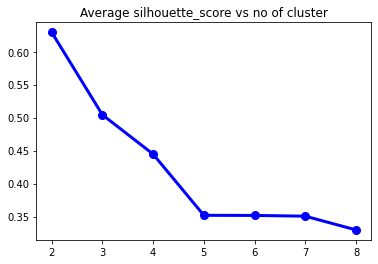

In [53]:
plt.title("Average silhouette_score vs no of cluster")
plt.plot(range(2,9), silhouette_scores, "bo-", color='blue',linewidth=3,markersize=8)

# k means determined value

In [54]:
start = time.time()
labelk=[]
cluster_center=[]
def kmean(data,num_clusters):
    km = KMeans(n_clusters=num_clusters,max_iter=10000)
    km.fit(data)
    labelk.append(km.labels_)
    cluster_center.append(km.cluster_centers_)
    return labelk,cluster_center
labelk=Parallel(n_jobs=8)(delayed(kmean)(x,num_clusters=6) for _ in range(1))[0]
end = time.time()
kmean_time=end-start


In [55]:
predicted1=labelk[0][0]
predicted1

array([3, 1, 1, 1, 3, 3, 1, 3, 1, 1, 3, 1, 1, 1, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 1, 1, 3, 3, 3, 1, 1, 3, 3, 3, 1, 1, 3, 1, 1, 3, 3, 1, 1, 3,
       3, 1, 3, 1, 3, 1, 2, 2, 2, 4, 2, 4, 2, 4, 2, 4, 4, 2, 4, 2, 4, 2,
       2, 4, 2, 4, 2, 2, 2, 2, 2, 2, 2, 2, 2, 4, 4, 4, 4, 2, 4, 2, 2, 2,
       4, 4, 4, 2, 4, 4, 4, 4, 4, 2, 4, 4, 5, 2, 0, 2, 5, 0, 4, 0, 2, 0,
       5, 2, 5, 2, 5, 5, 5, 0, 0, 2, 5, 2, 0, 2, 5, 0, 2, 2, 5, 0, 0, 0,
       5, 2, 2, 0, 5, 5, 2, 5, 5, 5, 2, 5, 5, 5, 2, 5, 5, 2])

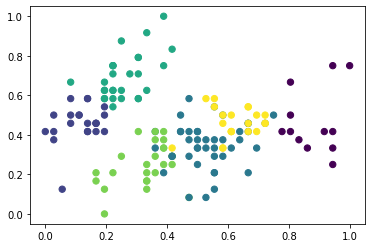

In [56]:
plt.scatter(x[:,0], x[:,1], c=predicted1, s=40, cmap='viridis')

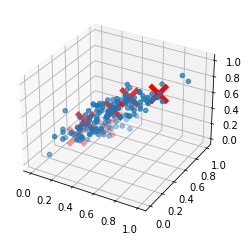

In [57]:
cluster_centers=labelk[1][0]
fig = plt.figure()
ax = fig.add_subplot(111, projection ='3d')
ax.scatter(x[:, 0], x[:, 1], x[:, 2], marker ='o')
ax.scatter(cluster_centers[:, 0], cluster_centers[:, 1],
           cluster_centers[:, 2], marker ='x', color ='red',
           s = 300, linewidth = 5, zorder = 10)
  
plt.show()

# f1_score

In [ ]:
kmeans_f1=f1_score(y, predicted1,average='macro')
kmeans_f1

# adjusted_rand_score

In [ ]:
kmeans_adjust=adjusted_rand_score(y,predicted1)
kmeans_adjust

# silhouette_score

In [ ]:
kmeans_sil=silhouette_score(x,predicted1)
kmeans_sil

In [ ]:
details = {
    'name': 'K Means',
    'time': kmean_time,
    'f1_score':kmeans_f1,
    'adjusted_rand_score':kmeans_adjust,
    'silhouette_score':kmeans_sil 
}
with open(k, 'a') as json_file:
    json.dump(details, json_file)

# Agglomerative Clustering

In [58]:
%%time
labels=[]
def aggloc(i):
    aggloclust=AgglomerativeClustering(n_clusters=i).fit(x)
    print(aggloclust)
    labels.append(aggloclust.labels_)
    return labels
labels=Parallel(n_jobs=8)(delayed(aggloc)(6) for _ in range(1))[0]

Wall time: 2.2 s


In [59]:
start = time.time()
labels=[]

def aggloc(i):
    aggloclust=AgglomerativeClustering(n_clusters=i).fit(x)
    print(aggloclust)
    labels.append(aggloclust.labels_)
    return labels
labels=Parallel(n_jobs=8)(delayed(aggloc)(6) for _ in range(1))[0]
# time.sleep(3)
end = time.time()
agglo_time=end-start
# print("--- %s seconds ---"% (kmean_time))

In [60]:
predicted2=np.array(labels[0])
predicted2

array([2, 4, 4, 4, 2, 2, 2, 2, 4, 4, 2, 2, 4, 4, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 4, 2, 2, 2, 4, 4, 2, 2, 2, 4, 4, 2, 4, 4, 2, 2, 4, 4, 2,
       2, 4, 2, 4, 2, 4, 0, 0, 0, 3, 0, 0, 0, 3, 0, 3, 3, 0, 3, 0, 0, 0,
       0, 3, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 3, 3, 3, 0, 0, 0, 0, 0,
       0, 3, 3, 0, 3, 3, 0, 0, 0, 0, 3, 0, 5, 0, 5, 5, 5, 1, 3, 1, 0, 1,
       5, 0, 5, 0, 0, 5, 5, 1, 1, 0, 5, 0, 1, 0, 5, 1, 0, 0, 5, 1, 1, 1,
       5, 0, 0, 1, 5, 5, 0, 5, 5, 5, 0, 5, 5, 5, 0, 5, 5, 0], dtype=int64)

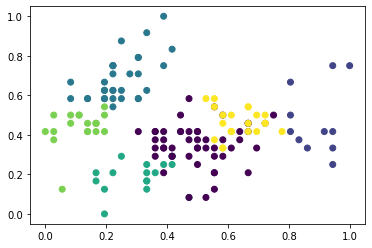

In [61]:
plt.scatter(x[:,0], x[:,1], c=labels)
plt.show()

In [ ]:
an_array = np.where(predicted2==0, 5, predicted2)
an_array2=np.where(an_array==1, 0, an_array)
predicted2_new=np.where(an_array2==5, 1, an_array2)
predicted2_new

# f1_score

In [ ]:
agglo_f1=f1_score(y, predicted2,average='macro')
agglo_f1

In [ ]:
f1_score(y, predicted2_new,average='macro')

# adjusted_rand_score

In [ ]:
agglo_adjust=adjusted_rand_score(y,predicted2)
agglo_adjust

In [ ]:
adjusted_rand_score(y,predicted2_new)

# silhouette_score

In [ ]:
agglo_sil=silhouette_score(x,predicted2)
agglo_sil

In [ ]:
silhouette_score(x,predicted2_new)

In [ ]:
details = {
    'name': 'Agglomerative',
    'time': agglo_time,
    'f1_score':agglo_f1,
    'adjusted_rand_score':agglo_adjust,
    'silhouette_score':agglo_sil 
}
with open(k, 'a') as json_file:
    json.dump(details, json_file)

# DBSCAN 

In [ ]:
x.ndim

In [ ]:
# MIn samples is 2*2

# find eps value

In [ ]:
neighbors = NearestNeighbors(n_neighbors=4)
neighbors_fit = neighbors.fit(x)
distances, indices = neighbors_fit.kneighbors(x)

In [ ]:
distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.plot(distances)

In [ ]:
# renge_eps=[0.22,0.229,0.239,0.249,0.255,0.265,0.27] #iris dataset ,min_samples=5
# renge_eps=[0.45,0.49,0.5,0.504,0.505]  #wine data set optimam 0.504,min_samples=5
# renge_eps=[0.3,0.303,0.4] # glass data set optimam 0.3 ,min_samples=2 renge_eps=[0.3,0.303,0.4]
# renge_eps=[0.27,0.28,0.3,0.4,0.32] #haberman
#renge_eps=[0.412] #satelite 
# renge_eps=np.arange(2,15,0.1)
# renge_eps=[0.77,0.775,0.779,0.78] for gas drift
for i in renge_eps:
    db = DBSCAN(eps=i,min_samples=8).fit(x)
    mask=np.zeros_like(db.labels_,dtype=bool)
    mask[db.core_sample_indices_]=True
    labels=db.labels_
    n_cluster=len(np.unique(labels))
    if(len(np.unique(labels))>0):
        print('eps value is '+ str(i))
        print(set(labels))
        avg=silhouette_score(x,labels)
        len(np.unique(labels))
        print(avg)
        print('Number of cluster ',n_cluster )


In [ ]:
min_sample=range(2,10)
for i in min_sample:
        print('Min sample is '+ str(i))
        db = DBSCAN(eps=0.775,min_samples=i).fit(x)
        mask=np.zeros_like(db.labels_,dtype=bool)
        mask[db.core_sample_indices_]=True
        labels=db.labels_
        if(len(np.unique(labels))>1):
            avg=silhouette_score(x,labels)
            len(np.unique(labels))
            
        
        print("For min sample values"+str(i),"Total no of clusters are "+str(len(np.unique(labels))))
        
    

In [ ]:
start = time.time()
labels=[]

def scan(i):
    db = DBSCAN(eps=0.775,min_samples=i)
    db.fit(x)
    labels = db.labels_
    return labels
labels=Parallel(n_jobs=8)(delayed(scan)(6) for _ in range(1))[0]
n_cluster=len(np.unique(labels))
print("Number of clusters: ",n_cluster )
end = time.time()
dbscan_time=end-start
dbscan_time

In [ ]:
# predicted3=np.array(labels[0])
# predicted3
predicted3=labels
predicted3

In [ ]:
plt.scatter(x[:,0], x[:,1], c=predicted3, cmap='viridis')

# f1_score

In [ ]:
dbscan_f1=f1_score(y, predicted3,average='macro')
dbscan_f1

# adjusted_rand_score

In [ ]:
dbscan_adjust=adjusted_rand_score(y,predicted3)
dbscan_adjust

# silhouette_score

In [ ]:
dbscan_sil=silhouette_score(x,predicted3)
dbscan_sil

In [ ]:
details = {
    'name': 'dbscan',
    'time': dbscan_time,
    'f1_score':dbscan_f1,
    'adjusted_rand_score':dbscan_adjust,
    'silhouette_score':dbscan_sil 
}
with open(k, 'a') as json_file:
    json.dump(details, json_file)

# optics

In [ ]:
renge_eps=range(2,15)           #renge_eps=range(2,25) for glass
                                #renge_eps=range(16,40)  for haberman
                                #min_samples=i,xi=0.11) satelite
for i in renge_eps:
    db = OPTICS(min_samples=i,xi=0.11).fit(x)
    labels=db.labels_
    n_cluster=len(np.unique(labels))
    
    if(n_cluster==6):
        avg=silhouette_score(x,labels)            #n_cluster==3 and avg>0.4 for iris
        print(i)
        print(set(labels))
        print('Number of cluster ',n_cluster )
        print("for eps value "+str(i),"Average silvate score is ",avg)

In [ ]:
# for satelit image
# 0.1
# 0.07
# 0.09
# 0.08
# xi=0.03, clusters=6 sil=-0.49

In [ ]:
start = time.time()
labels=[]
def clus():
    clustering = OPTICS(min_samples=6).fit(x)    #min_samples=6,xi=0.08
    labels.append(clustering.labels_)
    return labels
labels=Parallel(n_jobs=8)(delayed(clus)() for _ in range(1))[0]
end = time.time()
optics_time=end-start

In [ ]:
optics_time

In [ ]:
n_cluster=len(np.unique(labels))
print("Number of clusters: ",n_cluster )

In [ ]:
predicted4=np.array(labels)[0]
Optics_sil=silhouette_score(x,predicted4)
Optics_sil

In [ ]:
predicted4=np.array(labels)[0]
predicted4

In [ ]:
plt.scatter(x[:,0], x[:,1], c=predicted4, s=40, cmap='viridis')

# f1_score

In [ ]:
Optics_f1=f1_score(y, predicted4,average='macro')
Optics_f1

# adjusted_rand_score

In [ ]:
Optics_adjust=adjusted_rand_score(y,predicted4)
Optics_adjust

# silhouette_score

In [ ]:
Optics_sil=silhouette_score(x,predicted4)
Optics_sil

In [ ]:
details = {
    'name': 'Optics',
    'time': optics_time,
    'f1_score':Optics_f1,
    'adjusted_rand_score':Optics_adjust,
    'silhouette_score':Optics_sil 
}
with open(k, 'a') as json_file:
    json.dump(details, json_file)

# GaussianMixture

In [ ]:
start = time.time()
labels=[]
def gauss(i):
    gmm = GaussianMixture(n_components=i).fit(x)
    labels.append(gmm.predict(x))
    return labels
labels=Parallel(n_jobs=8)(delayed(gauss)(6) for _ in range(1))[0][0]
end = time.time()
GaussianMixture_time=end-start

In [ ]:
predicted5 = labels
predicted5

In [ ]:
plt.scatter(x[:, 0], x[:, 1], c=predicted5, s=40, cmap='viridis');

# f1_score

In [ ]:
GaussianMixture_f1=f1_score(y, predicted5,average='macro')
GaussianMixture_f1

# adjusted_rand_score

In [ ]:
GaussianMixture_adjust=adjusted_rand_score(y,predicted5)
GaussianMixture_adjust

# silhouette_score

In [ ]:
GaussianMixture_sil=silhouette_score(x,predicted5)
GaussianMixture_sil

In [ ]:
details = {
    'name': 'GaussianMixture',
    'time': GaussianMixture_time,
    'f1_score':GaussianMixture_f1,
    'adjusted_rand_score':GaussianMixture_adjust,
    'silhouette_score':GaussianMixture_sil 
}
with open(k, 'a') as json_file:
    json.dump(details, json_file)

# Mean shift

# the kernel bandwidth parameter

In [ ]:
from sklearn.cluster import  estimate_bandwidth
bandwidth = estimate_bandwidth(x,quantile=0.5)
bandwidth
labels1=[]
cluster_center=[]
bandwidth


In [ ]:
start = time.time()
def mean(i):
    ms=MeanShift(bandwidth,cluster_all=True)                #bandwidth=0.31223 for iris
                                                 #andwidth=0.778  for wine
                                                 #bandwidth=0.6165
                                                #bandwidth=0.47 for haberman
                                                #bbandwidth=0.749 for satelite
                                                #bandwidth=0.8195 for nurse
    ms.fit(x)
    labels1.append(ms.labels_)
    cluster_center.append(ms.cluster_centers_)
    return cluster_center,labels1
result1=Parallel(n_jobs=8)(delayed(mean)(3) for _ in range(1))[0]
end = time.time()
MeanShift_time=end-start
MeanShift_time

In [ ]:
MeanShift_sil=silhouette_score(x,result1[1][0])
print(MeanShift_sil)
predicted6=result1[1][0]
n_cluster=len(np.unique(predicted6))
print("Number of clusters: ",n_cluster )
MeanShift_sil=silhouette_score(x,predicted6)
MeanShift_sil

In [ ]:
predicted6=result1[1][0]
n_cluster=len(np.unique(predicted6))
print("Number of clusters: ",n_cluster )

In [ ]:
center=result1[0][0]
print(center)

In [ ]:
predicted6

In [ ]:
cluster_centers=result1[0][0]
fig = plt.figure()
ax = fig.add_subplot(111, projection ='3d')
ax.scatter(x[:, 0], x[:, 1], x[:, 2], marker ='o')
ax.scatter(cluster_centers[:, 0], cluster_centers[:, 1],
           cluster_centers[:, 2], marker ='x', color ='red',
           s = 300, linewidth = 5, zorder = 10)
  
plt.show()

# f1_score

In [ ]:
MeanShift_f1=f1_score(y, predicted6,average='macro')
MeanShift_f1

# adjusted_rand_score

In [ ]:
MeanShift_adjust=adjusted_rand_score(y,predicted6)
MeanShift_adjust

# silhouette_score

In [ ]:
MeanShift_sil=silhouette_score(x,predicted6)
MeanShift_sil

In [ ]:
details = {
    'name': 'MeanShift',
    'time': MeanShift_time,
    'f1_score':MeanShift_f1,
    'adjusted_rand_score':MeanShift_adjust,
    'silhouette_score':MeanShift_sil 
}
with open(k, 'a') as json_file:
    json.dump(details, json_file)

# Affinity Propagation

In [ ]:
labels=[]
cluster_center=[]

In [ ]:
start=time.time()
def affinity(i):
    af = AffinityPropagation(preference=-5,random_state=None)      #iris data (preference=-3,random_state=None)
                                                                    # wine (preference=-5,random_state=None)
                                                                    #preference=-9,random_state=None   haberman
                                                                    #preference=-9,random_state=None for satelite
    af.fit(x)
    labels.append(af.labels_)
    cluster_center.append(af.cluster_centers_)
    return cluster_center,labels
result2=Parallel(n_jobs=8)(delayed(affinity)(6) for _ in range(1))[0]
end = time.time()
affinity_time=end-start
affinity_time

In [ ]:
predicted7=result2[1][0]
affinity_sil=silhouette_score(x,predicted7)
n_cluster=len(np.unique(predicted6))
print("Number of clusters: ",n_cluster )
affinity_sil

In [ ]:
center=result2[0][0]
print(center)

In [ ]:
predicted7=result2[1][0]
predicted7

In [ ]:
plt.scatter(x[:, 0], x[:, 1], c=predicted7, s=40, cmap='viridis')

# f1_score

In [ ]:
affinity_f1=f1_score(y, predicted7,average='macro')
affinity_f1

# adjusted_rand_score

In [ ]:
affinity_adjust=adjusted_rand_score(y,predicted7)
affinity_adjust

# silhouette_score

In [ ]:
affinity_sil=silhouette_score(x,predicted7)
affinity_sil

In [ ]:
details = {
    'name': 'Affinity_Propagation',
    'time': affinity_time,
    'f1_score':affinity_f1,
    'adjusted_rand_score':affinity_adjust,
    'silhouette_score':affinity_sil 
}
with open(k, 'a') as json_file:
    json.dump(details, json_file)

# Spectral clustering

In [ ]:
start = time.time()
labels=[]
def spect(i):
    sc = SpectralClustering(n_clusters = i)
    sc.fit(x)
    labels.append(sc.labels_)
    return labels
labels=Parallel(n_jobs=8)(delayed(spect)(6) for _ in range(1))[0][0]
end = time.time()
Spectral_time=end-start
Spectral_time

In [ ]:
n_clusters_ = len(np.unique(labels))
n_clusters_

In [ ]:
predicted8=labels
predicted8

In [ ]:
plt.scatter(x[:, 0], x[:, 1], c=predicted8, s=40, cmap='viridis')

# f1_score

In [ ]:
Spectral_f1=f1_score(y, predicted8,average='macro')
Spectral_f1

# adjusted_rand_score

In [ ]:
Spectral_adjust=adjusted_rand_score(y,predicted8)
Spectral_adjust

# silhouette_score

In [ ]:
Spectral_sil=silhouette_score(x,predicted8)
Spectral_sil

In [ ]:
details = {
    'name': 'Spectral',
    'time': Spectral_time,
    'f1_score':Spectral_f1,
    'adjusted_rand_score':Spectral_adjust,
    'silhouette_score':Spectral_sil 
}
with open(k, 'a') as json_file:
    json.dump(details, json_file)

# Birch

In [ ]:
start = time.time()
labels=[]
def birch(i):
    br = Birch(n_clusters = i,threshold=0.327) #0.327
    br.fit(x)
    labels.append(br.labels_)
    return labels
labels=Parallel(n_jobs=8)(delayed(aggloc)(6) for _ in range(1))[0][0]
end = time.time()
Birch_time=end-start
Birch_time

In [ ]:
n_clusters_ = len(np.unique(labels))
n_clusters_

In [ ]:
predicted9=labels
plt.scatter(x[:, 0], x[:, 1], c=predicted9, s=40, cmap='viridis')

# f1_score

In [ ]:
Birch_f1=f1_score(y, predicted8,average='macro')
Birch_f1

# adjusted_rand_score

In [ ]:
Birch_adjust=adjusted_rand_score(y,predicted8)
Birch_adjust

# silhouette_score

In [ ]:
Birch_sil=silhouette_score(x,predicted8)
Birch_sil

In [ ]:
details = {
    'name': 'Birch',
    'time': Birch_time,
    'f1_score':Birch_f1,
    'adjusted_rand_score':Birch_adjust,
    'silhouette_score':Birch_sil 
}
with open(k, 'a') as json_file:
    json.dump(details, json_file)

# Ward hierarchical

In [ ]:
dandgram=sch.dendrogram(sch.linkage(x,method='ward'))

In [ ]:
start = time.time()
labels=[]
def ward(i):
    Agglomerat=AgglomerativeClustering(n_clusters=i,affinity='euclidean',linkage='ward').fit(x)
    labels.append(Agglomerat.labels_)
    return labels
labels=Parallel(n_jobs=8)(delayed(ward)(6) for _ in range(1))[0]
end = time.time()
ward_time=end-start
ward_time

In [ ]:
n_clusters_ = len(np.unique(labels))
n_clusters_

In [ ]:
predicted10=labels[0]
predicted10

In [ ]:
plt.scatter(x[:, 0], x[:, 1], c=predicted10, s=40, cmap='viridis')

# f1_score

In [ ]:
Ward_f1=f1_score(y, predicted10,average='macro')
Ward_f1

# adjusted_rand_score

In [ ]:
Ward_adjust=adjusted_rand_score(y,predicted10)
Ward_adjust

# silhouette_score

In [ ]:
Ward_sil=silhouette_score(x,predicted10)
Ward_sil

In [ ]:
details = {
    'name': 'Ward',
    'time': ward_time,
    'f1_score':Ward_f1,
    'adjusted_rand_score':Ward_adjust,
    'silhouette_score':Ward_sil 
}
with open(k, 'a') as json_file:
    json.dump(details, json_file)

# Self organizing map

In [ ]:
start = time.time()
labels=[]
def self(i):
    som = SOM(n_columns=5, n_rows=1, random_state=2)   #2 dimention 5 ouput so (n_columns=5, n_rows=1, random_state=2)
    labels = som.fit_predict(x)
    return labels
labels=Parallel(n_jobs=8)(delayed(self)(6) for _ in range(1))[0]
end = time.time()
self_time=end-start
self_time

In [ ]:
n_clusters_ = len(np.unique(labels))
n_clusters_

In [ ]:
predicted11=labels
predicted11

In [ ]:
plt.scatter(x[:, 0], x[:, 1], c=predicted11, s=40, cmap='viridis')

# f1_score

In [ ]:
self_f1=f1_score(y, predicted11,average='macro')
self_f1

# adjusted_rand_score

In [ ]:
self_adjust=adjusted_rand_score(y,predicted11)
self_adjust

# silhouette_score

In [ ]:
self_sil=silhouette_score(x,predicted11)
self_sil

In [ ]:
details = {
    'name': 'self',
    'time': self_time,
    'f1_score':self_f1,
    'adjusted_rand_score':self_adjust,
    'silhouette_score':self_adjust 
}
with open(k, 'a') as json_file:
    json.dump(details, json_file)